In [1]:
import numpy as np, matplotlib.pyplot as plt
from numpy import *
import pylab
import scipy as scipy
from scipy.io import wavfile
from numpy.fft import *
import scipy.signal as signal
from matplotlib.pyplot import *
import IPython
import cmath

# Helper Functions

In [2]:
def find_pitch(data):
    start = int(44100/300)
    end = int(44100/100)
    temp_max = data[start]
    temp_maxi = start
    start_freq = data[0]
    for i in range(start+1,end):     
        if data[i] > temp_max:
            temp_max = data[i]
            temp_maxi = i
        pitch_status = True if temp_max >= 0.7*start_freq else False                 
    return (pitch_status, temp_max, temp_maxi)

# Making a pitch tracker

## Perform STFT

In [3]:
samplerate, sound = wavfile.read('beauty.wav')
f, t, Zxx = signal.stft(sound, fs = samplerate, window = np.hanning(2048), nperseg = 2048, noverlap = 512)
IPython.display.display(IPython.display.Audio(sound, rate=samplerate))

## Compute Autocorrelation

Red depicts pitched frames
Blue depicts unpitched frames


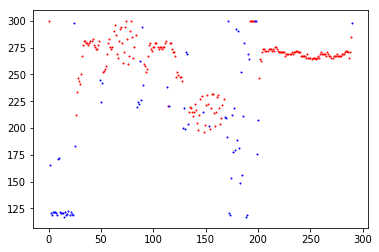

In [4]:
autocorrelated = np.conj(Zxx) * Zxx

time_domains = np.zeros(Zxx.shape, dtype = complex_)
for i in range(Zxx.shape[1]):
    time_domains[:, i] = np.fft.ifft(autocorrelated[:, i])

for i in range(time_domains.shape[1]):
    col = time_domains[:, i]
    peakBool, peak, peak_idx = find_pitch(col)
    
    if peakBool is True:
        plt.scatter(i, samplerate/peak_idx, c = 'r', s = 1)
    else:
        plt.scatter(i, samplerate/peak_idx, c = 'b', s = 1)
print("Red depicts pitched frames")
print("Blue depicts unpitched frames")

## We see in the latter part of the plot above that the vocalist is off pitch, we will intend to rectify this 

## Changing Pitch

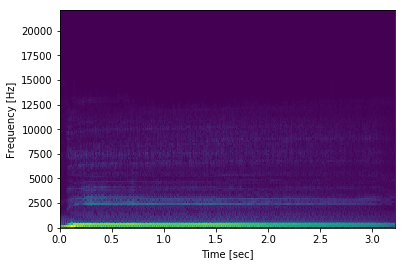

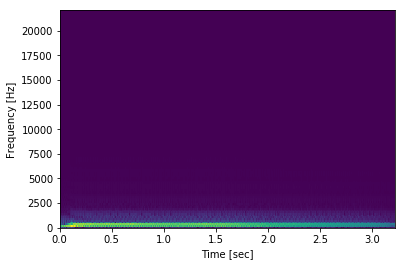

In [5]:
horrible = sound[303000:445000]
IPython.display.display(IPython.display.Audio(horrible, rate=samplerate))

f, t, Zxx = signal.spectrogram(horrible, samplerate)
plt.pcolormesh(t, f, Zxx**0.3)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

nyq = 0.5 * samplerate
normal_cutoff = 1500 / nyq
b, a = signal.butter(5, normal_cutoff, btype='low', analog=False)

lowpass_horrible = signal.filtfilt(b, a, horrible)

IPython.display.display(IPython.display.Audio(lowpass_horrible, rate=samplerate)) 
2
f, t, Sxx = signal.spectrogram(lowpass_horrible, samplerate)
plt.pcolormesh(t, f, Sxx**0.3)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Zero crossing Points

In [6]:
crossing_points = []
for i in range(len(lowpass_horrible)-1):
    if(lowpass_horrible[i]*lowpass_horrible[i+1]<0):
        crossing_points.append(i)

In [7]:
final_signal = np.zeros(161*len(crossing_points))
final_signal[0:36] = horrible[0:36]*np.hanning(36)
ct = 36
for i in range(2, len(crossing_points)-2, 2):
    data = horrible[crossing_points[i-2]:crossing_points[i+2]]
    window = np.hanning(len(data))
    data = window*data
    final_signal[ct:ct+len(data)] = data
    ct = ct + 161

final_signal = final_signal[0:int(len(final_signal)/2)]
final_music = np.array(np.append(sound[0: 303000], final_signal))
IPython.display.display(IPython.display.Audio(final_music, rate=samplerate)) 

Red depicts pitched frames
Blue depicts unpitched frames


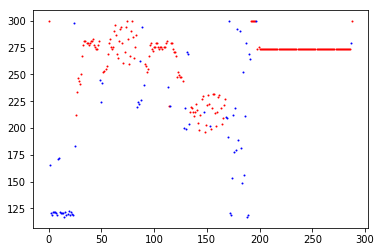

In [8]:
f, t, Zxx = signal.stft(final_music, fs = samplerate, window = np.hanning(2048), nperseg = 2048, noverlap = 512)
autocorrelated = np.conj(Zxx) * Zxx

time_domains = np.zeros(Zxx.shape, dtype = complex_)
for i in range(Zxx.shape[1]):
    time_domains[:, i] = np.fft.ifft(autocorrelated[:, i])

for i in range(time_domains.shape[1]):
    col = time_domains[:, i]
    peakBool, peak, peak_idx = find_pitch(col)
    
    if peakBool is True:
        plt.scatter(i, samplerate/peak_idx, c = 'r', s = 1)
    else:
        plt.scatter(i, samplerate/peak_idx, c = 'b', s = 1)
        
print("Red depicts pitched frames")
print("Blue depicts unpitched frames")

## We have successfully corrected the pitch of the respective samples to 274 as shown in the graph above